In [1]:
import collections
import os
import re
import json

import numpy as np
import pandas as pd
import nltk
import sklearn.cross_validation as skcv
import sklearn.decomposition as skd
import sklearn.ensemble as skens
import sklearn.feature_extraction.text as skft
import sklearn.metrics as skmetrics
import sklearn.naive_bayes as sknb
import sklearn.pipeline as skpipe
import ast
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid', color_codes=True, font_scale=1.3)
sns.set(style='white', color_codes=True, font_scale=1.3)

# Pre-process

In [2]:
stemmer = nltk.stem.PorterStemmer()
stopwords = nltk.corpus.stopwords.words('english')

raw_tweets = open('si_330_jpcarron_rawtweeets.json', 'r')

def preprocess(text, stemmer):
    output1 = []
    output2 = []
    
    saveFile = open('si_330_jpcarron_cleanedtweets.json', 'w')
    saveFile2 = open('si_330_jpcarron_cleanedtweets2.json', 'w')
    for x in text:
        pre_text = re.sub('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', 'URL', x)
        pre_text = re.sub('@([A-Za-z0-9_]+)', 'AT_USER', pre_text)
        pre_text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",pre_text).split())
        pre_text = pre_text.lower()
        out_text = stemmer.stem(pre_text)
        out_text = nltk.tokenize.wordpunct_tokenize(out_text)
        out_text = list(ngrams(out_text, 1))
        output1.append(out_text)
        out_text = list(ngrams(out_text, 2))
        output2.append(out_text)
    for x in output1:
        saveFile.write(json.dumps(x))
        saveFile.write('\n')
    for x in output2:
        saveFile2.write(json.dumps(x))
        saveFile2.write('\n')
    return output2


processed_api = preprocess(raw_tweets, stemmer)

# Train Classifier

### load dataset

In [3]:
df = pd.DataFrame.from_csv('tweet_sentiment_labels.csv', index_col=False)
df['processed_tweets'] = preprocess(df.Tweet, stemmer)

# for x in df.processed_tweets:
# #     print(x)
#     for y in x:
#         print(y)


trainer = df.copy()

trainer['Sentiment (Positive, Negative, or Neutral)'] = trainer['Sentiment (Positive, Negative, or Neutral)'].str.lower()
trainer['Sentiment (Positive, Negative, or Neutral)'] = trainer['Sentiment (Positive, Negative, or Neutral)'].str.strip()


trainer.loc[trainer['Sentiment (Positive, Negative, or Neutral)'] == "positive",'Sentiment (Positive, Negative, or Neutral)'] = 2
trainer.loc[trainer['Sentiment (Positive, Negative, or Neutral)'] == "postive",'Sentiment (Positive, Negative, or Neutral)'] = 2
trainer.loc[trainer['Sentiment (Positive, Negative, or Neutral)'] == "positve",'Sentiment (Positive, Negative, or Neutral)'] = 2

trainer.loc[trainer['Sentiment (Positive, Negative, or Neutral)'] == "negative",'Sentiment (Positive, Negative, or Neutral)'] = 0
trainer.loc[trainer['Sentiment (Positive, Negative, or Neutral)'] == "netative",'Sentiment (Positive, Negative, or Neutral)'] = 0

trainer.loc[trainer['Sentiment (Positive, Negative, or Neutral)'] == "neutral",'Sentiment (Positive, Negative, or Neutral)'] = 1
trainer.loc[trainer['Sentiment (Positive, Negative, or Neutral)'] == "netural",'Sentiment (Positive, Negative, or Neutral)'] = 1

trainer = trainer.dropna()
trainer.head()

,Tweet,Student,"Sentiment (Positive, Negative, or Neutral)",processed_tweets
0,"AT_USER i loved winter so much, thank you for ...",EXAMPLE,2,"[((at,), (user,)), ((user,), (i,)), ((i,), (lo..."
1,i don't like winter URL,EXAMPLE,0,"[((i,), (don,)), ((don,), (t,)), ((t,), (like,..."
2,registration for winter is this friday,EXAMPLE,1,"[((registration,), (for,)), ((for,), (winter,)..."
3,winter wonderland: see top 20 photos from mich...,Aaron Fogle,1,"[((winter,), (wonderland,)), ((wonderland,), (..."
4,"get $20 off your lyft ride w\\ promo code \""ar...",Aaron Fogle,2,"[((get,), (20,)), ((20,), (off,)), ((off,), (y..."


### Extract Features

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics
import matplotlib.pyplot as plt
from nltk.util import ngrams
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import stopwords
from nltk.metrics import f_measure, accuracy, precision, recall, scores


def load_training_data(data):
    
    posdf = trainer.loc[trainer['Sentiment (Positive, Negative, or Neutral)'] == 2]
    negdf = trainer.loc[trainer['Sentiment (Positive, Negative, or Neutral)'] == 0]
    neutraldf = trainer.loc[trainer['Sentiment (Positive, Negative, or Neutral)'] == 1]

    ####################################################################################################################
    ####################################################################################################################
    '''Train'''
    
    stopset = list(set(stopwords.words('english')))

    def word_feats(words):
        return dict([(word, True) for word in words if word not in stopset])
    
    labeled_names = ([(name, 'Positive') for name in posdf.processed_tweets] +
                     [(name, 'Negative') for name in negdf.processed_tweets] +
                     [(name, 'Neutral') for name in neutraldf.processed_tweets])


    pos_feats = [(word_feats(f), 'positive') for f in posdf.processed_tweets]
    neg_feats = [(word_feats(f), 'negative') for f in negdf.processed_tweets]
    neutral_feats = [(word_feats(f), 'neutral') for f in neutraldf.processed_tweets]
    
    trainfeats = pos_feats + neg_feats + neutral_feats
    
    dftrain, dftest = trainfeats[:800], trainfeats[800:]
    
    
    classifier = nltk.NaiveBayesClassifier.train(dftrain)
    
    print(nltk.classify.util.accuracy(classifier, dftest))
    
    ###############################################################################################################
    '''Train classifier on whole labeledset'''
    
    classifier = nltk.NaiveBayesClassifier.train(trainfeats)
    
#     for x in posdf.processed_tweets:
#         print(x)
    
    return classifier
    
load_training_data(trainer)

0.09780439121756487


# Sentiment Analysis

In [5]:
# Part 4: Sentiment Analysis
# Read cleaned tweets from stream file, 
# Apply trained classifiers, and generate label. 
# Output to json file.
def sentiment_analysis(classifier):

        
    tweet = []
    tweet_label = []
    some = processed_api[:1000]
        

    stopset = list(set(stopwords.words('english')))

    def word_feats(words):
        return dict([(word, True) for word in words if word not in stopset])    
        
    feats = [(word_feats(f)) for f in processed_api]
    
    for x in feats:
        labeler = classifier.classify(x)
        tweet.append(x)
        tweet_label.append(labeler)
        
#     for x in tweet[:2]:
#         print(x,'\n')
#     for x in tweet_label[:2]:
#         print (x,'\n')
        
    CMON = [(word_feats(f), classifier.classify(f)) for f in feats]
    saveFile = open('si_330_jpcarron_labelledtweets.json', 'w')
    for x in CMON:
        saveFile.write(json.dumps(str(x)))
        saveFile.write('\n')


sentiment_analysis(load_training_data(trainer))
#Save the cleaned tweets with sentiments as si_330_youruniquename_labelledtweets.json

0.09780439121756487


# Step 5

In [6]:
templist = []
sentlist = []
# readfile = open('si_330_jpcarron_labelledtweets.json', 'r')
with open('si_330_jpcarron_labelledtweets.json') as graph_file:
    for line in graph_file:
        data = json.loads(line)
        templist.append(ast.literal_eval(data))
for x in templist:
    sentlist.append(x[1])

In [7]:
yolist = []
with open('si_330_jpcarron_rawtweeets.json') as graph_file:
    for line in graph_file:
        data = json.loads(line)
        yolist.append(ast.literal_eval(data))
        
# for x in yolist[:10]:
#     print(x)

In [8]:
finalzip = list(zip(yolist, sentlist))
saveit = open('si_330_jpcarron_zippedtweets.json','w')
for x in finalzip:
    if x[1] == 'positive':
        saveit.write(json.dumps(str(x[0])))
        saveit.write('\n')

In [9]:
thisdf = pd.DataFrame.from_records(finalzip)
thisdf.head()

,0,1
0,"{'user': 'Bar9266', 'time': 'Sun Dec 06 01:32:...",neutral
1,"{'user': 'melanieHs6931', 'time': 'Sun Dec 06 ...",positive
2,"{'user': 'AzizAlnafisah', 'time': 'Sun Dec 06 ...",negative
3,"{'user': 'MissT117', 'time': 'Sun Dec 06 01:32...",neutral
4,"{'user': 'Catwoman7000', 'time': 'Sun Dec 06 0...",neutral


In [10]:
dates =[]
for x in thisdf[0]:
    dates.append(x['time'])
thisdf.index = dates
thisdf.tail()

,0,1
Sun Dec 06 01:52:12 +0000 2015,"{'user': 'brunatsantana', 'time': 'Sun Dec 06 ...",positive
Sun Dec 06 01:52:13 +0000 2015,"{'user': 'The_Best_Smart', 'time': 'Sun Dec 06...",negative
Sun Dec 06 01:52:13 +0000 2015,"{'user': 'BomberSports', 'time': 'Sun Dec 06 0...",neutral
Sun Dec 06 01:52:13 +0000 2015,"{'user': 'C_Clontz', 'time': 'Sun Dec 06 01:52...",negative
Sun Dec 06 01:52:13 +0000 2015,"{'user': 'Mad_Max523', 'time': 'Sun Dec 06 01:...",negative


In [11]:
import vincent

def time_series_tweets():
    #open datafile with tweets and sentiments
    #Append data
    

    with open('si_330_jpcarron_rawtweeets.json') as graph_file:
        d = dict()
        time_array = []
        alist = []
        for line in graph_file:
            data = json.loads(line)
            alist.append(ast.literal_eval(data))
        for x in alist:
            time_array.append(x['time'])

        # a list of "1" to count the dates
        ones = [1]*len(time_array)
        
        # the index of the series
        idx = pd.DatetimeIndex(time_array)
        #print idx
        # the actual series (at series of 1s for the moment)
        t_array = pd.Series(ones, index=idx)
        #print t_array

        # Resampling / bucketing
        t_array = t_array.resample('5s', how='sum').fillna(0)
        time_chart = vincent.Line(t_array)
        time_chart.axis_titles(x='Time', y='Freq')
        time_chart.to_json('term_freq.json')
        
time_series_tweets()

In [12]:
def time_series_tweets():
    #open datafile with tweets and sentiments
    #Append data
    

    with open('si_330_jpcarron_zippedtweets.json') as graph_file:
        d = dict()
        time_array = []
        alist = []
        for line in graph_file:
            data = json.loads(line)
            alist.append(ast.literal_eval(data))
        for x in alist:
            time_array.append(x['time'])

        # a list of "1" to count the dates
        ones = [1]*len(time_array)
        
        # the index of the series
        idx = pd.DatetimeIndex(time_array)
        #print idx
        # the actual series (at series of 1s for the moment)
        t_array = pd.Series(ones, index=idx)
        #print t_array

        # Resampling / bucketing
        t_array = t_array.resample('5s', how='sum').fillna(0)
        time_chart = vincent.Line(t_array)
        time_chart.axis_titles(x='Time', y='Freq')
        time_chart.to_json('term_freq.json')
        
time_series_tweets()

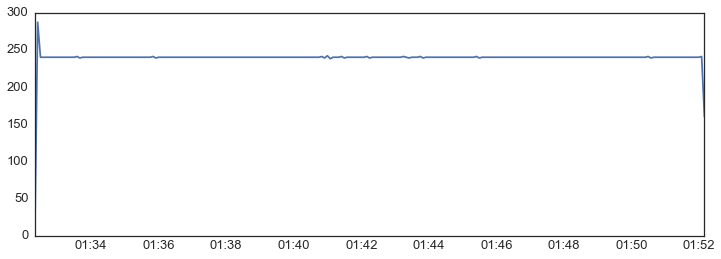

In [17]:
fig, ax = plt.subplots(figsize=(12,4))
t_array.ix['2015-12-06',].plot(ax=ax)

In [14]:
with open('si_330_jpcarron_rawtweeets.json') as graph_file:
    d = dict()
    time_array = []
    alist = []
    for line in graph_file:
        data = json.loads(line)
        alist.append(ast.literal_eval(data))
    for x in alist:
        time_array.append(x['time'])

    # a list of "1" to count the dates
    ones = [1]*len(time_array)

    # the index of the series
    idx = pd.DatetimeIndex(time_array)
    #print idx
    # the actual series (at series of 1s for the moment)
    t_array = pd.Series(ones, index=idx)
    #print t_array

    # Resampling / bucketing
    t_array = t_array.resample('5s', how='sum').fillna(0)
    
#         time_chart = vincent.Line(t_array)
#         time_chart.axis_titles(x='Time', y='Freq')
#         time_chart.to_json('term_freq.json')

2015-12-06 01:32:20+00:00      1
2015-12-06 01:32:25+00:00    287
2015-12-06 01:32:30+00:00    240
2015-12-06 01:32:35+00:00    240
2015-12-06 01:32:40+00:00    240
2015-12-06 01:32:45+00:00    240
2015-12-06 01:32:50+00:00    240
2015-12-06 01:32:55+00:00    240
2015-12-06 01:33:00+00:00    240
2015-12-06 01:33:05+00:00    240
2015-12-06 01:33:10+00:00    240
2015-12-06 01:33:15+00:00    240
2015-12-06 01:33:20+00:00    240
2015-12-06 01:33:25+00:00    240
2015-12-06 01:33:30+00:00    240
2015-12-06 01:33:35+00:00    241
2015-12-06 01:33:40+00:00    239
2015-12-06 01:33:45+00:00    240
2015-12-06 01:33:50+00:00    240
2015-12-06 01:33:55+00:00    240
2015-12-06 01:34:00+00:00    240
2015-12-06 01:34:05+00:00    240
2015-12-06 01:34:10+00:00    240
2015-12-06 01:34:15+00:00    240
2015-12-06 01:34:20+00:00    240
2015-12-06 01:34:25+00:00    240
2015-12-06 01:34:30+00:00    240
2015-12-06 01:34:35+00:00    240
2015-12-06 01:34:40+00:00    240
2015-12-06 01:34:45+00:00    240
          

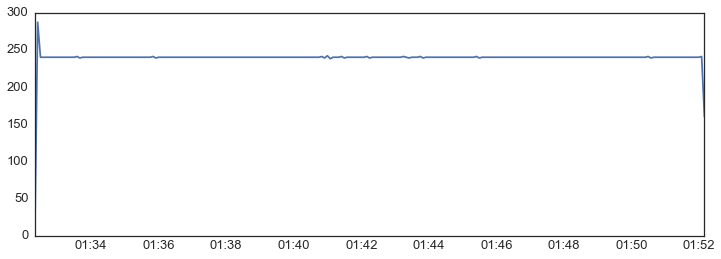

In [16]:
fig, ax = plt.subplots(figsize=(12,4))
t_array.ix['2015-12-06',].plot(ax=ax)